In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import xgboost as xgb
import joblib

from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
sns.set_style('whitegrid')
%matplotlib inline

data_path = '/content/drive/MyDrive/Projetos/Trabalho_IA/archive/'

try:
    df_receitas = pd.read_csv(data_path + 'RAW_recipes.csv')
    df_train = pd.read_csv(data_path + 'interactions_train.csv')
    df_validation = pd.read_csv(data_path + 'interactions_validation.csv')
    df_test = pd.read_csv(data_path + 'interactions_test.csv')
except FileNotFoundError:
    print("Erro: Verifique se o caminho para a pasta 'archive' está correto.")

print("Dados carregados com sucesso!")
print(f"Temos {len(df_train)} interações de treino.")
print(f"Temos {len(df_validation)} interações de validação.")
print(f"Temos {len(df_test)} interações de teste.")

Dados carregados com sucesso!
Temos 698901 interações de treino.
Temos 7023 interações de validação.
Temos 12455 interações de teste.


In [6]:
print("Amostra dos dados de treino:")
print(df_train.head())

Amostra dos dados de treino:
   user_id  recipe_id        date  rating      u       i
0     2046       4684  2000-02-25     5.0  22095   44367
1     2046        517  2000-02-25     5.0  22095   87844
2     1773       7435  2000-03-13     5.0  24732  138181
3     1773        278  2000-03-13     4.0  24732   93054
4     2046       3431  2000-04-07     5.0  22095  101723


In [7]:
# Informações gerais sobre o DataFrame
print("\nInformações do df_train:")
df_train.info()


Informações do df_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698901 entries, 0 to 698900
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    698901 non-null  int64  
 1   recipe_id  698901 non-null  int64  
 2   date       698901 non-null  object 
 3   rating     698901 non-null  float64
 4   u          698901 non-null  int64  
 5   i          698901 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 32.0+ MB


In [8]:
# Estatísticas descritivas da coluna 'rating'
print("\nEstatísticas da coluna 'rating':")
print(df_train['rating'].describe())


Estatísticas da coluna 'rating':
count    698901.000000
mean          4.574090
std           0.959022
min           0.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64


/tmp/ipython-input-3186563511.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df_train, palette='viridis')


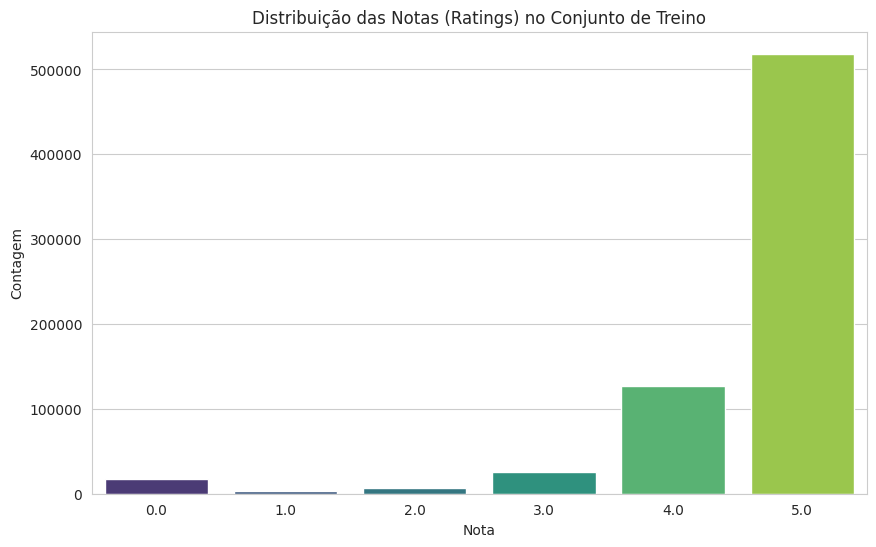

In [9]:
# Plotando a distribuição das notas (ratings)
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df_train, palette='viridis')
plt.title('Distribuição das Notas (Ratings) no Conjunto de Treino')
plt.xlabel('Nota')
plt.ylabel('Contagem')
plt.show()

In [10]:
# ANALISANDO AS RECEITAS
print("Amostra dos dados de receitas:")
print(df_receitas.head())

Amostra dos dados de receitas:
                                         name      id  minutes  \
0  arriba   baked winter squash mexican style  137739       55   
1            a bit different  breakfast pizza   31490       30   
2                   all in the kitchen  chili  112140      130   
3                          alouette  potatoes   59389       45   
4          amish  tomato ketchup  for canning   44061      190   

   contributor_id   submitted  \
0           47892  2005-09-16   
1           26278  2002-06-17   
2          196586  2005-02-25   
3           68585  2003-04-14   
4           41706  2002-10-25   

                                                tags  \
0  ['60-minutes-or-less', 'time-to-make', 'course...   
1  ['30-minutes-or-less', 'time-to-make', 'course...   
2  ['time-to-make', 'course', 'preparation', 'mai...   
3  ['60-minutes-or-less', 'time-to-make', 'course...   
4  ['weeknight', 'time-to-make', 'course', 'main-...   

                                    

In [11]:
# Informações gerais
print("\nInformações do df_receitas:")
df_receitas.info()


Informações do df_receitas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


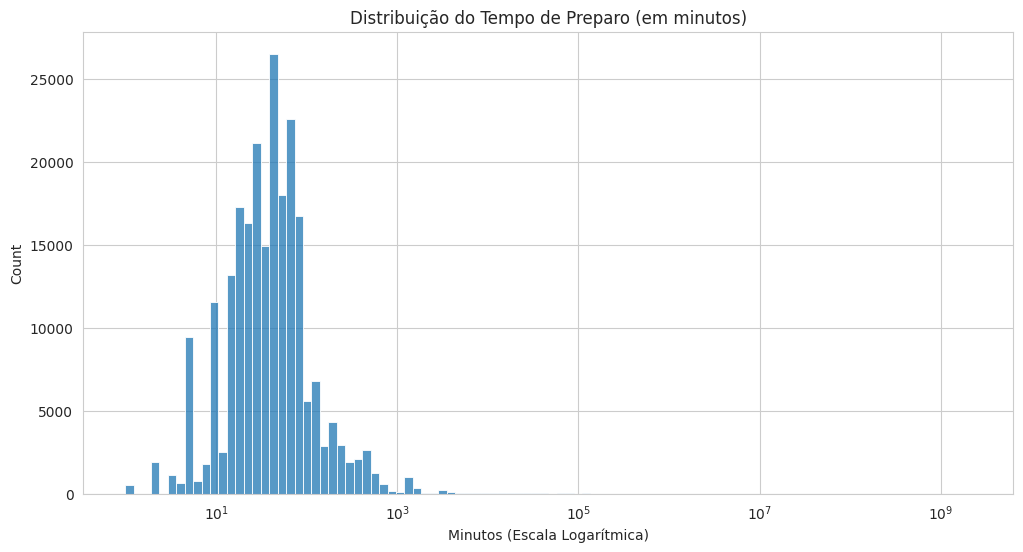

In [12]:
# Análise do tempo de preparo ('minutes')
plt.figure(figsize=(12, 6))
sns.histplot(df_receitas['minutes'], bins=100, log_scale=True)
plt.title('Distribuição do Tempo de Preparo (em minutos)')
plt.xlabel('Minutos (Escala Logarítmica)')
plt.show()

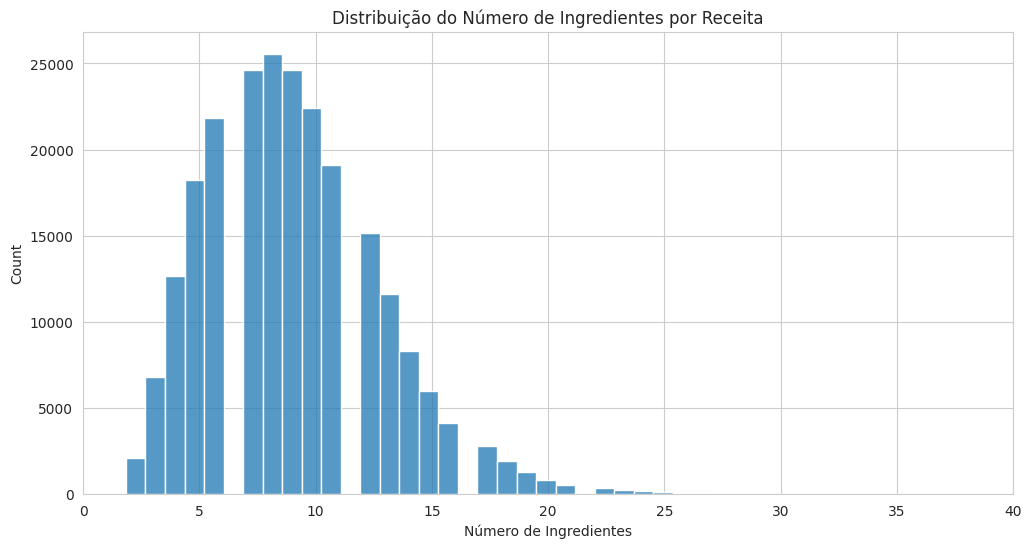

In [13]:
# Análise do número de ingredientes ('n_ingredients')
plt.figure(figsize=(12, 6))
sns.histplot(df_receitas['n_ingredients'], bins=50)
plt.title('Distribuição do Número de Ingredientes por Receita')
plt.xlabel('Número de Ingredientes')
plt.xlim(0, 40)
plt.show()

In [14]:

print("Calculando features de receitas...")
media_rating_por_item = df_train.groupby('recipe_id')['rating'].mean().rename('media_rating_item')
num_avaliacoes_por_item = df_train.groupby('recipe_id')['rating'].count().rename('num_avaliacoes_item')

df_receitas = df_receitas.merge(media_rating_por_item, left_on='id', right_index=True, how='left')
df_receitas = df_receitas.merge(num_avaliacoes_por_item, left_on='id', right_index=True, how='left')


print("Calculando features de usuários...")
media_rating_por_usuario = df_train.groupby('user_id')['rating'].mean().rename('media_rating_usuario')
num_avaliacoes_por_usuario = df_train.groupby('user_id')['rating'].count().rename('num_avaliacoes_usuario')
df_users = pd.DataFrame(media_rating_por_usuario).join(num_avaliacoes_por_usuario)


Calculando features de receitas...
Calculando features de usuários...


In [15]:
# CRIAÇÃO DE OUTRAS FEATURES (Temporais, Tags, Nutrição)
# Features Temporais
print("Criando features temporais...")
df_receitas['submitted'] = pd.to_datetime(df_receitas['submitted'])
df_receitas['ano_publicacao'] = df_receitas['submitted'].dt.year
df_receitas['mes_publicacao'] = df_receitas['submitted'].dt.month
data_recente = df_receitas['submitted'].max()
df_receitas['idade_receita_dias'] = (data_recente - df_receitas['submitted']).dt.days

Criando features temporais...


In [16]:
# 2.2 Features de Tags
print("Criando features de tags...")
df_receitas['tags_limpas'] = df_receitas['tags'].apply(lambda x: ' '.join(ast.literal_eval(x)))
vectorizer = CountVectorizer(max_features=30, binary=True)
tags_matrix = vectorizer.fit_transform(df_receitas['tags_limpas'])
df_tags = pd.DataFrame(tags_matrix.toarray(), index=df_receitas.index, columns=['tag_' + tag for tag in vectorizer.get_feature_names_out()])
df_receitas = pd.concat([df_receitas, df_tags], axis=1)

Criando features de tags...


In [17]:
# Feature de Nutrição
print("Criando features de nutrição...")
def tratar_coluna_nutricao(df):
    df_copy = df.copy()
    coluna_nutrition_str = df_copy['nutrition'].fillna('[]').astype(str)
    lista_nutrition = coluna_nutrition_str.apply(ast.literal_eval)
    df_nutrition = pd.DataFrame(lista_nutrition.tolist(), index=df_copy.index)
    df_nutrition.columns = [f'nutri_{i}' for i in range(df_nutrition.shape[1])]
    df_final = pd.concat([df_copy, df_nutrition], axis=1)
    df_final = df_final.drop('nutrition', axis=1)
    return df_final
df_receitas = tratar_coluna_nutricao(df_receitas)

Criando features de nutrição...


In [18]:
media_geral_rating = df_train['rating'].mean()
print(f"A média geral de rating (nossa melhor estimativa) é: {media_geral_rating:.4f}")

# Adicione a feature de desvio do item diretamente no DataFrame de receitas que depois vai para todos os items finais
df_receitas['item_desvio_media_geral'] = df_receitas['media_rating_item'] - media_geral_rating

def criar_conjunto_final(df_interacoes, df_receitas, df_users, media_global):
    df_final = df_interacoes.merge(df_receitas, left_on='recipe_id', right_on='id', how='left')
    df_final = df_final.merge(df_users, on='user_id', how='left')

    df_final['media_rating_item'].fillna(media_global, inplace=True)
    df_final['media_rating_usuario'].fillna(media_global, inplace=True)
    df_final.fillna(0, inplace=True)
    return df_final

train_final = criar_conjunto_final(df_train, df_receitas, df_users, media_geral_rating)
validation_final = criar_conjunto_final(df_validation, df_receitas, df_users, media_geral_rating)
test_final = criar_conjunto_final(df_test, df_receitas, df_users, media_geral_rating)

# Esta feature que vai pegar o "Humor" do cliente, precisa ser criada depois que ja exite os conjuntos finais
train_final['rating_desvio_usuario'] = train_final['rating'] - train_final['media_rating_usuario']
validation_final['rating_desvio_usuario'] = validation_final['rating'] - validation_final['media_rating_usuario']
test_final['rating_desvio_usuario'] = test_final['rating'] - test_final['media_rating_usuario']

print("\nFeature de desvio do item criada:")
print(train_final[['media_rating_item', 'item_desvio_media_geral']].head())

print("\nFeature de desvio do usuário criada:")
print(train_final[['rating', 'media_rating_usuario', 'rating_desvio_usuario']].head())

A média geral de rating (nossa melhor estimativa) é: 4.5741


/tmp/ipython-input-786255104.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['media_rating_item'].fillna(media_global, inplace=True)
/tmp/ipython-input-786255104.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac


Feature de desvio do item criada:
   media_rating_item  item_desvio_media_geral
0           4.944444                 0.370355
1           5.000000                 0.425910
2           4.440000                -0.134090
3           4.416667                -0.157423
4           4.875000                 0.300910

Feature de desvio do usuário criada:
   rating  media_rating_usuario  rating_desvio_usuario
0     5.0                   5.0                    0.0
1     5.0                   5.0                    0.0
2     5.0                   4.5                    0.5
3     4.0                   4.5                   -0.5
4     5.0                   5.0                    0.0


In [19]:
target = 'rating'
features_para_remover = [
    target, 'user_id', 'recipe_id', 'id', 'name', 'submitted', 'date',
    'tags', 'description', 'ingredients', 'steps', 'tags_limpas'
]
train_cols = train_final.columns
features_para_remover_existentes = [col for col in features_para_remover if col in train_cols]
features = [col for col in train_final.columns if col not in features_para_remover_existentes]

X_train = train_final[features]
y_train = train_final[target]
X_val = validation_final[features]
y_val = validation_final[target]
X_test = test_final[features]
y_test = test_final[target]

print(f"\nNúmero final de features no modelo: {len(features)}")


Número final de features no modelo: 52


In [20]:
print("--- Calculando o Modelo Baseline ---")
baseline_model = DummyRegressor(strategy='mean')
baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_val)

# Calcular o RMSE para o baseline
mse_baseline = mean_squared_error(y_val, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)

print(f"RMSE do Modelo Baseline (na validação): {rmse_baseline:.4f}")

--- Calculando o Modelo Baseline ---
RMSE do Modelo Baseline (na validação): 1.3468


In [21]:
rf_simples = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=15,
    random_state=42,
    n_jobs=-1
)

print("\n--- Treinando RandomForest Simplificado (com dados corrigidos) ---")
rf_simples.fit(X_train, y_train)

# Avaliação
y_pred_treino_rf = rf_simples.predict(X_train)
mse_treino_rf = mean_squared_error(y_train, y_pred_treino_rf)
rmse_treino_rf = np.sqrt(mse_treino_rf)

print(f"RMSE de Treino do RandomForest: {rmse_treino_rf:.4f}")

y_pred_val_rf = rf_simples.predict(X_val)
mse_val_rf = mean_squared_error(y_val, y_pred_val_rf)
rmse_val_rf = np.sqrt(mse_val_rf)

print(f"RMSE de Validação do RandomForest: {rmse_val_rf:.4f}")

xgb_simples = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    max_depth=7,
    learning_rate=0.05,
    gamma=1,
    random_state=42,
    n_jobs=-1
)

print("\n--- Treinando XGBoost Simplificado (com dados corrigidos) ---")
xgb_simples.fit(X_train, y_train)

# Avaliação
y_pred_treino_xgb = xgb_simples.predict(X_train)
mse_treino_xgb = mean_squared_error(y_train, y_pred_treino_xgb)
rmse_treino_xgb = np.sqrt(mse_treino_xgb)
print(f"RMSE de Treino do XGBoost: {rmse_treino_xgb:.4f}")

y_pred_val_xgb = xgb_simples.predict(X_val)
mse_val_xgb = mean_squared_error(y_val, y_pred_val_xgb)
rmse_val_xgb = np.sqrt(mse_val_xgb)
print(f"RMSE de Validação do XGBoost: {rmse_val_xgb:.4f}")

print(f"\nLembre-se: O RMSE do Baseline é: {rmse_baseline:.4f}")


--- Treinando RandomForest Simplificado (com dados corrigidos) ---
RMSE de Treino do RandomForest: 0.0066
RMSE de Validação do RandomForest: 0.1241

--- Treinando XGBoost Simplificado (com dados corrigidos) ---
RMSE de Treino do XGBoost: 0.0204
RMSE de Validação do XGBoost: 0.0772

Lembre-se: O RMSE do Baseline é: 1.3468


In [27]:
# Aumentei o valor do min_simple_leaf para combater o overfitting
rf_refinado = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=40,
    random_state=42,
    n_jobs=-1
)

print("\n--- Treinando RandomForest Refinado ---")
rf_refinado.fit(X_train, y_train)

# Validação do treinamento refinado
y_pred_val_rf_refinado = rf_refinado.predict(X_val)
rmse_val_rf_refinado = np.sqrt(mean_squared_error(y_val, y_pred_val_rf_refinado))
print(f"RMSE de Validação (Random Forest Refinado): {rmse_val_rf_refinado:.4f}")

# Aumentei o número de árvores e diminui a taxa de aprendizado
xgb_refinado = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    max_depth=7,
    learning_rate=0.02,
    gamma=1,
    random_state=42,
    n_jobs=-1
)

print("\n--- Treinando XGBoost Refinado ---")
xgb_refinado.fit(X_train, y_train)

# Validação modelo XGBoost refinado
y_pred_val_xgb_refinado = xgb_refinado.predict(X_val)
rmse_val_xgb_refinado = np.sqrt(mean_squared_error(y_val, y_pred_val_xgb_refinado))
print(f"RMSE de Validação (XGBoost Refinado): {rmse_val_xgb_refinado:.4f}")

print(f"\nLembre-se: O RMSE do Baseline é: {rmse_baseline:.4f}")


--- Treinando RandomForest Refinado ---
RMSE de Validação (Random Forest Refinado): 0.1542

--- Treinando XGBoost Refinado ---
RMSE de Validação (XGBoost Refinado): 0.0771

Lembre-se: O RMSE do Baseline é: 1.3468


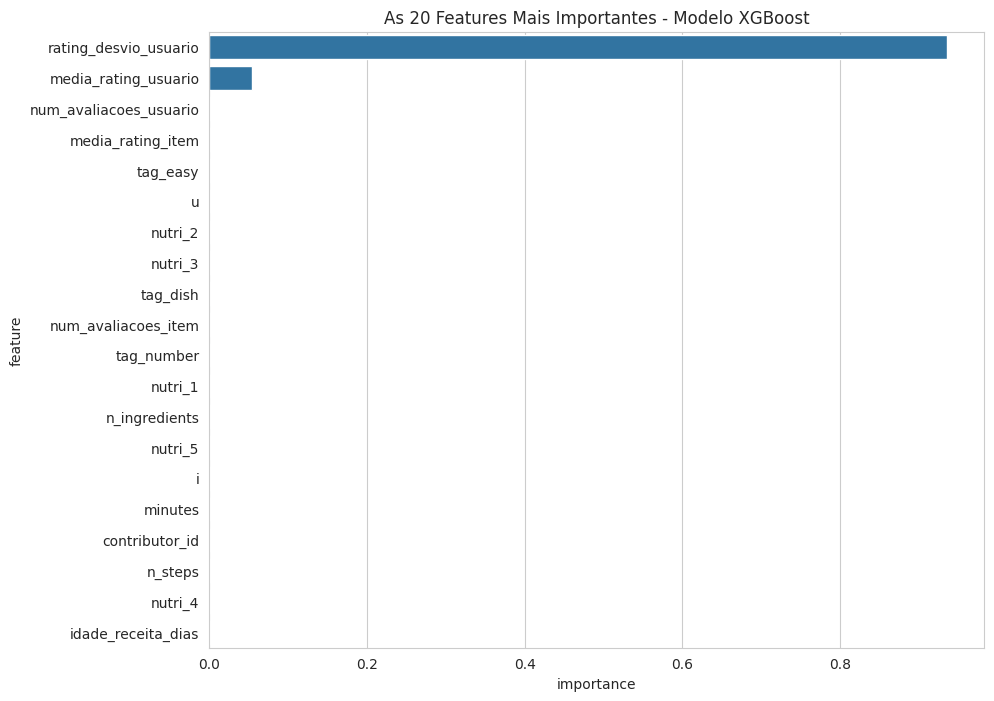

In [24]:
# Criar um DataFrame com a importância das features
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_refinado.feature_importances_
}).sort_values('importance', ascending=False)

# Plotar as 20 features mais importantes
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('As 20 Features Mais Importantes - Modelo XGBoost')
plt.show()

In [25]:
# Fazer previsões no conjunto de TESTE
y_pred_test_xgb = xgb_refinado.predict(X_test)
mse_test_xgb = mean_squared_error(y_test, y_pred_test_xgb)
rmse_test_xgb = np.sqrt(mse_test_xgb)
print(f"RMSE FINAL do XGBoost no Conjunto de TESTE: {rmse_test_xgb:.4f}")

RMSE FINAL do XGBoost no Conjunto de TESTE: 0.0947


In [ ]:
# Nome do arquivo para o modelo
model_filename = 'modelo_xgboost_final.joblib'

# Salva o seu melhor modelo treinado
joblib.dump(xgb_refinado, model_filename)
print(f"Modelo salvo com sucesso em: {model_filename}")

vectorizer_filename = 'tags_vectorizer.joblib'
joblib.dump(vectorizer, vectorizer_filename)
print(f"Vectorizer salvo com sucesso em: {vectorizer_filename}")

Modelo salvo com sucesso em: modelo_xgboost_final.joblib
Vectorizer salvo com sucesso em: tags_vectorizer.joblib
